In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import time
import os

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Mall_Customers.xlsx to Mall_Customers.xlsx


In [4]:
import io
df = pd.read_excel(io.BytesIO(uploaded['Mall_Customers.xlsx']))
df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Please upload the Mall_Customers.xlsx file using the file selector...


Saving Mall_Customers.xlsx to Mall_Customers (1).xlsx
Dataset loaded. Shape: (200, 5)
First 5 rows:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

--- Basic info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-n

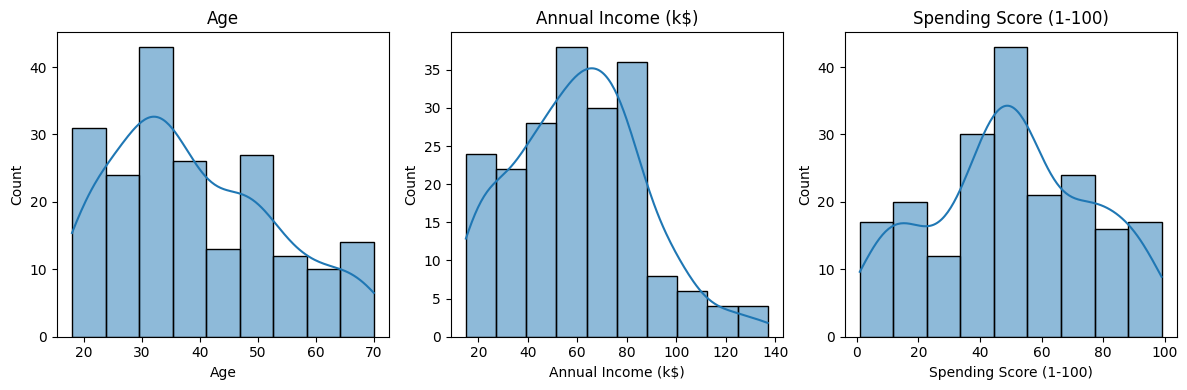

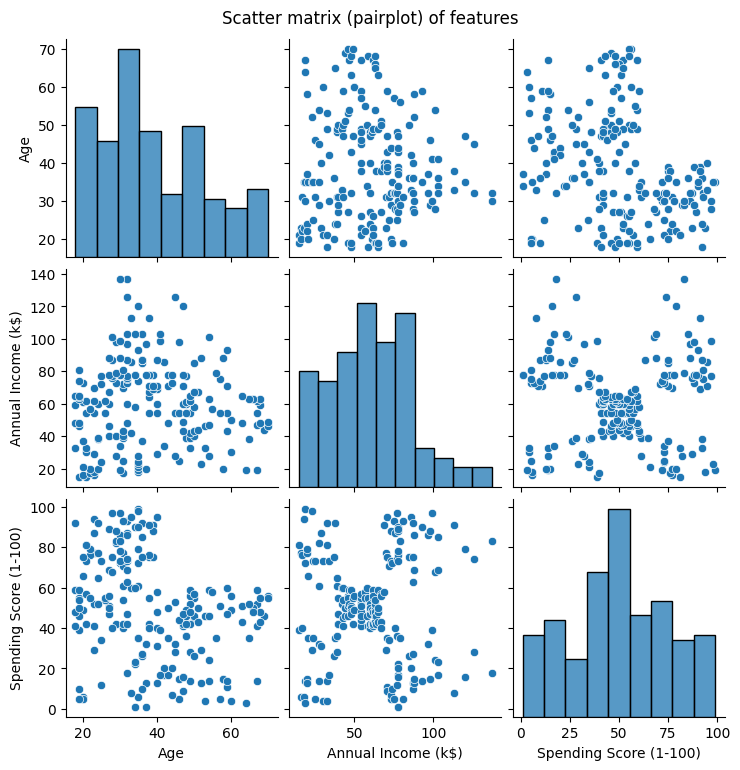


Means (original):
Age                       38.85
Annual Income (k$)        60.56
Spending Score (1-100)    50.20
dtype: float64

Stds (original):
Age                       13.969007
Annual Income (k$)        26.264721
Spending Score (1-100)    25.823522
dtype: float64
Running k=1...
Running k=2...
Running k=3...
Running k=4...
Running k=5...
Running k=6...
Running k=7...
Running k=8...
Running k=9...
Running k=10...


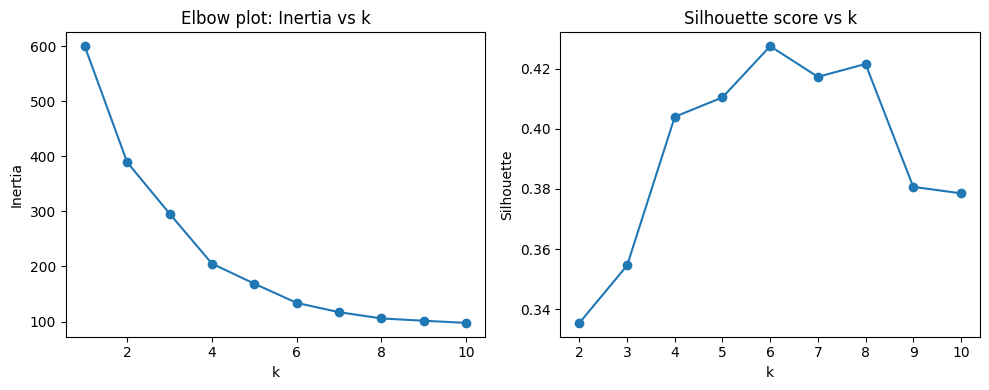


Inertia by k:
k=1: inertia=600.0000
k=2: inertia=389.3862
k=3: inertia=296.0785
k=4: inertia=205.2251
k=5: inertia=168.7618
k=6: inertia=133.8683
k=7: inertia=117.0116
k=8: inertia=105.6440
k=9: inertia=101.4144
k=10: inertia=97.5503

Silhouette by k:
k=1: silhouette=nan
k=2: silhouette=0.33547192894004574
k=3: silhouette=0.35456123961265024
k=4: silhouette=0.4039582785148566
k=5: silhouette=0.41040013089361826
k=6: silhouette=0.42742814991580175
k=7: silhouette=0.417231894954916
k=8: silhouette=0.42151089566733746
k=9: silhouette=0.38068109607418665
k=10: silhouette=0.37852102660113246
Best k by silhouette: 6 (inspect elbow plot too)
Suggested default (elbow heuristic/fallback): 3
Running our KMeans with k=6...
Iter 1, centroid shift 1.067905
Iter 2, centroid shift 0.328096
Iter 3, centroid shift 0.178516
Iter 4, centroid shift 0.130751
Iter 5, centroid shift 0.103803
Iter 6, centroid shift 0.163944
Iter 7, centroid shift 0.298990
Iter 8, centroid shift 0.209839
Iter 9, centroid shif

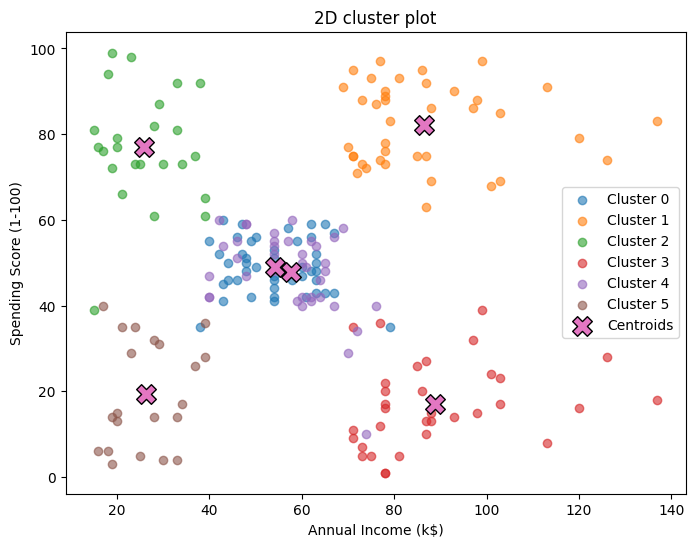

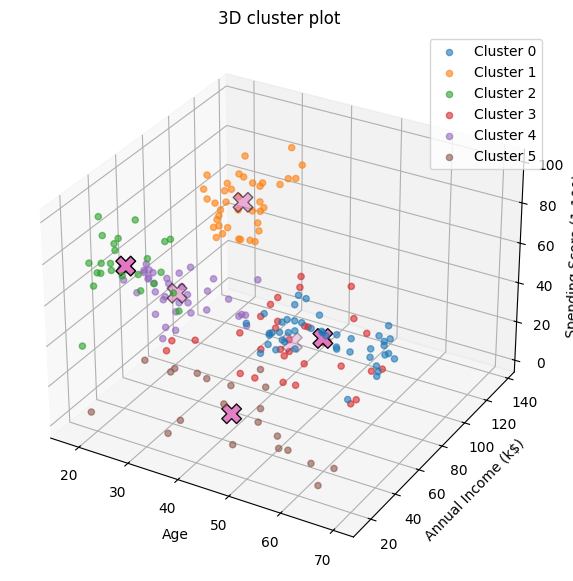


Comparing with scikit-learn KMeans...
Scikit-learn KMeans runtime: 0.0725 s
Sklearn inertia: 133.86842085478855
Sklearn n_iter (per run): 6

Sklearn centroids (original scale):
         Age  Annual Income (k$)  Spending Score (1-100)
0  56.333333           54.266667               49.066667
1  26.794872           57.102564               48.128205
2  41.939394           88.939394               16.969697
3  32.692308           86.538462               82.128205
4  25.000000           25.260870               77.608696
5  45.523810           26.285714               19.380952

Centroid comparison (ours vs sklearn):
        ours                                              sklearn  \
         Age Annual Income (k$) Spending Score (1-100)        Age   
0  56.333333          54.266667              49.066667  56.333333   
1  32.692308          86.538462              82.128205  26.794872   
2  25.250000          25.833333              76.916667  41.939394   
3  41.939394          88.939394       

In [5]:
# Experiment-7: K-Means Clustering From Scratch
# Colab-ready script. Save as a .py file or paste into a Colab notebook cell and run.

# Author: ChatGPT
# Date: 2025-11-02

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans as SKLearnKMeans

# ---------------------------
# 0. Load dataset (flexible)
# ---------------------------
# The dataset path included in the environment is '/mnt/data/Mall_Customers.xlsx'.
# In Colab you'll usually upload the file or mount Drive. This code will try
# a few approaches (local path, then upload widget).

DATA_PATH = '/mnt/data/Mall_Customers.xlsx'

if os.path.exists(DATA_PATH):
    df = pd.read_excel(DATA_PATH)
else:
    # Try to let user upload in Colab
    try:
        from google.colab import files
        print('Please upload the Mall_Customers.xlsx file using the file selector...')
        uploaded = files.upload()
        # take first uploaded file
        fname = next(iter(uploaded.keys()))
        df = pd.read_excel(fname)
    except Exception:
        raise FileNotFoundError(
            f"Couldn't find {DATA_PATH} and not running in Colab upload mode. Please provide the Excel/CSV file.")

print('Dataset loaded. Shape:', df.shape)
print('First 5 rows:')
print(df.head())

# ---------------------------
# 1. Basic exploration & preprocessing
# ---------------------------
print('\n--- Basic info ---')
df.info()

print('\n--- Summary statistics ---')
print(df.describe())

# Check missing values
print('\nMissing values per column:')
print(df.isnull().sum())

# For this experiment we will use numeric features: Age, Annual Income (k$), Spending Score (1-100)
# Attempt to auto-detect columns by common names; otherwise list numeric columns and ask user to edit.
expected_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
cols = []
for c in expected_cols:
    if c in df.columns:
        cols.append(c)

if not cols:
    # fall back to numeric columns (excluding ID-like columns)
    numeric = df.select_dtypes(include=np.number).columns.tolist()
    print('\nDetected numeric columns:', numeric)
    # attempt reasonable defaults
    # If dataset follows the popular Mall_Customers dataset, columns are: CustomerID, Gender, Age, Annual Income (k$), Spending Score (1-100)
    for c in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
        if c in numeric:
            cols.append(c)
    # if still empty, pick the last three numeric columns
    if not cols and len(numeric) >= 3:
        cols = numeric[-3:]

print('\nUsing features:', cols)
X_raw = df[cols].copy()

# Handle missing values: simple strategy - drop rows with missing numeric values
if X_raw.isnull().any().any():
    print('\nMissing values found. Dropping rows with missing values...')
    X_raw = X_raw.dropna()

# Provide distribution visuals (histograms & scatter matrix)
plt.figure(figsize=(12, 4))
for i, c in enumerate(cols):
    plt.subplot(1, len(cols), i+1)
    sns.histplot(X_raw[c], kde=True)
    plt.title(c)
plt.tight_layout()
plt.show()

# Pairplot (scatter matrix) - may be slow for very large datasets
sns.pairplot(X_raw)
plt.suptitle('Scatter matrix (pairplot) of features', y=1.02)
plt.show()

# Standardize or Normalize?
# K-Means relies on Euclidean distance — features should be on comparable scales.
# We'll standardize (zero mean, unit variance) which works well when features have different units
# (age in years, income in thousands, score 1-100). We'll keep both scaled versions if user wants.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw.values)

# Also keep MinMax scaled (0-1) for optional plotting
minmax = MinMaxScaler()
X_mm = minmax.fit_transform(X_raw.values)

print('\nMeans (original):')
print(X_raw.mean())
print('\nStds (original):')
print(X_raw.std())

# ---------------------------
# 2. K-Means from scratch (NumPy only)
# ---------------------------

def euclidean_dist_squared(a, b):
    """Compute squared Euclidean distance between each row of a and each row of b.
    a: (n_samples, n_features)
    b: (n_centroids, n_features)
    returns: (n_samples, n_centroids)
    """
    # Efficient broadcasting: (a-b)^2 sum over features
    # Use (x-y)^2 = x^2 + y^2 - 2xy trick for speed and numeric stability
    a_sq = np.sum(a**2, axis=1).reshape(-1, 1)  # (n,1)
    b_sq = np.sum(b**2, axis=1).reshape(1, -1)  # (1,k)
    cross = a.dot(b.T)  # (n,k)
    dists = a_sq + b_sq - 2*cross
    # numerical safety
    dists = np.maximum(dists, 0.0)
    return dists


def initialize_centroids(X, k, random_state=None, method='kmeans++'):
    rng = np.random.RandomState(random_state)
    n_samples = X.shape[0]
    if method == 'random':
        indices = rng.choice(n_samples, size=k, replace=False)
        centroids = X[indices]
        return centroids

    # KMeans++
    centroids = np.zeros((k, X.shape[1]))
    # 1. choose one centroid uniformly at random
    first_idx = rng.randint(0, n_samples)
    centroids[0] = X[first_idx]

    # 2..k: choose next centroids with probability proportional to D(x)
    for i in range(1, k):
        dists = euclidean_dist_squared(X, centroids[:i])
        nearest_sq = np.min(dists, axis=1)
        probs = nearest_sq / np.sum(nearest_sq)
        cumulative = np.cumsum(probs)
        r = rng.rand()
        next_idx = np.searchsorted(cumulative, r)
        # In rare numerical cases, cap index
        if next_idx >= n_samples:
            next_idx = n_samples - 1
        centroids[i] = X[next_idx]
    return centroids


def assign_clusters(X, centroids):
    dists = euclidean_dist_squared(X, centroids)
    labels = np.argmin(dists, axis=1)
    return labels


def update_centroids(X, labels, k):
    n_features = X.shape[1]
    centroids = np.zeros((k, n_features))
    for i in range(k):
        members = X[labels == i]
        if len(members) == 0:
            # If a cluster lost all members, we'll keep centroid as zeros for now
            # (caller may choose to reinitialize or leave as-is)
            centroids[i] = np.zeros(n_features)
        else:
            centroids[i] = np.mean(members, axis=0)
    return centroids


def compute_inertia(X, centroids, labels):
    dists = euclidean_dist_squared(X, centroids)
    sum_sq = 0.0
    for i in range(centroids.shape[0]):
        sum_sq += np.sum(dists[labels == i, i])
    return sum_sq


def kmeans(X, k, max_iters=100, tol=1e-4, random_state=None, init='kmeans++', verbose=False):
    # X is numpy array
    centroids = initialize_centroids(X, k, random_state=random_state, method=init)
    for it in range(1, max_iters+1):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        # For empty clusters we reinitialize from random data points
        for i in range(k):
            if np.all(new_centroids[i] == 0):
                # pick a random data point
                idx = np.random.randint(0, X.shape[0])
                new_centroids[i] = X[idx]
        shift = np.linalg.norm(centroids - new_centroids)
        centroids = new_centroids
        if verbose:
            print(f'Iter {it}, centroid shift {shift:.6f}')
        if shift <= tol:
            break
    inertia = compute_inertia(X, centroids, labels)
    return {
        'centroids': centroids,
        'labels': labels,
        'n_iter': it,
        'inertia': inertia
    }

# ---------------------------
# 3. Part B: Choosing k (Elbow & Silhouette)
# ---------------------------

def evaluate_k_range(X, k_min=1, k_max=10, random_state=42, init='kmeans++'):
    inertias = []
    silhouettes = []
    models = []
    for k in range(k_min, k_max+1):
        print(f'Running k={k}...')
        res = kmeans(X, k, max_iters=200, tol=1e-4, random_state=random_state, init=init)
        inertias.append(res['inertia'])
        # silhouette undefined for k=1
        if k > 1:
            sil = silhouette_score(X, res['labels'])
        else:
            sil = np.nan
        silhouettes.append(sil)
        models.append(res)
    return inertias, silhouettes, models

# Evaluate for a sensible range, e.g., 1..10
k_min, k_max = 1, 10
inertias, silhouettes, models = evaluate_k_range(X_scaled, k_min, k_max, random_state=42, init='kmeans++')

ks = list(range(k_min, k_max+1))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ks, inertias, marker='o')
plt.title('Elbow plot: Inertia vs k')
plt.xlabel('k')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(ks, silhouettes, marker='o')
plt.title('Silhouette score vs k')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.tight_layout()
plt.show()

print('\nInertia by k:')
for k, val in zip(ks, inertias):
    print(f'k={k}: inertia={val:.4f}')
print('\nSilhouette by k:')
for k, val in zip(ks, silhouettes):
    print(f'k={k}: silhouette={val}')

# The user should inspect the elbow and silhouette plots to pick k. We will choose a k automatically as the
# k with the highest silhouette score (excluding k=1), but the elbow method might differ. We'll print both choices.
best_k_by_sil = int(np.nanargmax(silhouettes) + k_min)
best_k_by_elbow = 3  # fallback; often 3-5 for customer segmentation - user should adjust after looking at plot
print(f'Best k by silhouette: {best_k_by_sil} (inspect elbow plot too)')
print(f'Suggested default (elbow heuristic/fallback): {best_k_by_elbow}')

# ---------------------------
# 4. Part C: Run K-Means with chosen k and show results
# ---------------------------
chosen_k = best_k_by_sil if best_k_by_sil >= 2 else best_k_by_elbow
print(f'Running our KMeans with k={chosen_k}...')
res = kmeans(X_scaled, chosen_k, max_iters=300, tol=1e-4, random_state=42, init='kmeans++', verbose=True)
centroids = res['centroids']
labels = res['labels']
print('n_iter:', res['n_iter'])
print('inertia:', res['inertia'])

# Map centroids back to original feature scale for interpretability
centroids_original = scaler.inverse_transform(centroids)
centroid_df = pd.DataFrame(centroids_original, columns=cols)
centroid_df['cluster'] = centroid_df.index
print('\nFinal centroids (original feature scale):')
print(centroid_df)

cluster_sizes = pd.Series(labels).value_counts().sort_index()
print('\nCluster sizes:')
print(cluster_sizes)

# Compute per-cluster averages on original data
X_orig_df = pd.DataFrame(X_raw.values, columns=cols)
X_orig_df['cluster'] = labels
cluster_stats = X_orig_df.groupby('cluster').mean()
print('\nCluster averages (original scale):')
print(cluster_stats)

# Interpret clusters: produce a short textual summary
interpretations = []
for i, row in cluster_stats.iterrows():
    desc = f'Cluster {i}: '
    parts = []
    for c in cols:
        parts.append(f"{c}={row[c]:.2f}")
    desc += ', '.join(parts)
    interpretations.append(desc)

print('\nCluster interpretations (raw averages):')
for s in interpretations:
    print('-', s)

# ---------------------------
# Visualize clusters
# ---------------------------
# 2D scatter: choose any two features (here Income vs Spending Score is common)
feat_x = cols[1] if len(cols) > 1 else cols[0]
feat_y = cols[2] if len(cols) > 2 else cols[1]

plt.figure(figsize=(8,6))
for i in range(chosen_k):
    mask = labels == i
    plt.scatter(X_orig_df.loc[mask, feat_x], X_orig_df.loc[mask, feat_y], label=f'Cluster {i}', alpha=0.6)
plt.scatter(centroid_df[feat_x], centroid_df[feat_y], marker='X', s=200, edgecolor='k', label='Centroids')
plt.xlabel(feat_x)
plt.ylabel(feat_y)
plt.legend()
plt.title('2D cluster plot')
plt.show()

# 3D scatter if we have 3 features
if X_scaled.shape[1] >= 3:
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(chosen_k):
        mask = labels == i
        ax.scatter(X_orig_df.loc[mask, cols[0]], X_orig_df.loc[mask, cols[1]], X_orig_df.loc[mask, cols[2]], label=f'Cluster {i}', alpha=0.6)
    ax.scatter(centroid_df[cols[0]], centroid_df[cols[1]], centroid_df[cols[2]], marker='X', s=200, edgecolor='k')
    ax.set_xlabel(cols[0]); ax.set_ylabel(cols[1]); ax.set_zlabel(cols[2])
    ax.legend()
    plt.title('3D cluster plot')
    plt.show()

# ---------------------------
# 5. Part D: Compare with scikit-learn KMeans
# ---------------------------
print('\nComparing with scikit-learn KMeans...')
start = time.perf_counter()
sk_model = SKLearnKMeans(n_clusters=chosen_k, init='k-means++', random_state=42, n_init=10, max_iter=300)
sk_model.fit(X_scaled)
end = time.perf_counter()

print(f'Scikit-learn KMeans runtime: {end-start:.4f} s')
print('Sklearn inertia:', sk_model.inertia_)
print('Sklearn n_iter (per run):', sk_model.n_iter_)

# Compare centroids (map sklearn centroids back to original scale)
sk_centroids_original = scaler.inverse_transform(sk_model.cluster_centers_)
sk_centroid_df = pd.DataFrame(sk_centroids_original, columns=cols)
print('\nSklearn centroids (original scale):')
print(s_k_centroid_df if 's_k_centroid_df' in globals() else sk_centroid_df)

# Print side-by-side centroid comparison
compare_df = pd.concat([centroid_df.set_index('cluster'), sk_centroid_df.reset_index(drop=True).set_index(sk_centroid_df.index)], axis=1, keys=['ours', 'sklearn'])
print('\nCentroid comparison (ours vs sklearn):')
print(compare_df)

# Runtime for our implementation (measured)
start = time.perf_counter()
_ = kmeans(X_scaled, chosen_k, max_iters=300, tol=1e-4, random_state=42, init='kmeans++')
end = time.perf_counter()
print(f"Our implementation runtime (one run): {end-start:.4f} s")

print('\n--- End of script ---')

# Note for the user:
# 1) Inspect the elbow and silhouette plots to pick k. The script defaults to the silhouette best k.
# 2) You can switch scaling (X_mm for 0-1) or use raw features (X_raw.values) if desired.
# 3) If you want me to adapt any plot styling, cluster-interpretation text, or export results to CSV, tell me and I'll update the script.
